In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F   # 현재 미사용이면 주석/삭제

from data import trainloader, testloader, classes
from nonsoftmaxmlp import MLP_NoSoftmax
from softmaxmlp import MLP_WithSoftmax


def train_model(model, trainloader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    use_softmax_head = isinstance(model, MLP_WithSoftmax)
    criterion = nn.NLLLoss() if use_softmax_head else nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            if use_softmax_head:
                # 수치 안정성: clamp로 log(0) 방지
                probs = outputs.clamp_min(1e-12)
                loss = criterion(torch.log(probs), labels)
                preds = torch.argmax(probs, dim=1)
            else:
                loss = criterion(outputs, labels)      # logits + CE
                preds = torch.argmax(outputs, dim=1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        acc = 100.0 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(trainloader):.4f}, Acc: {acc:.2f}%")

    print("Training Finished.")
    return model




In [6]:
# 테스트 함수도 같이 정의해두세요 (없으면 추가)
@torch.no_grad()
def test_model(model, testloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device).eval()

    correct, total = 0, 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    print(f"Test Accuracy: {100.0 * correct / total:.2f}%")

# ---- 실제 호출부 ----
print("\n===== Training MLP (No Softmax) =====")
model_a = MLP_NoSoftmax()
model_a = train_model(model_a, trainloader, epochs=2, lr=0.001)  # 먼저 epoch=2 정도로 확인
test_model(model_a, testloader)

print("\n===== Training MLP (With Softmax) =====")
model_b = MLP_WithSoftmax()
model_b = train_model(model_b, trainloader, epochs=2, lr=0.001)
test_model(model_b, testloader)



===== Training MLP (No Softmax) =====
Epoch [1/2] - Loss: 1.6501, Acc: 41.05%
Epoch [2/2] - Loss: 1.4206, Acc: 49.83%
Training Finished.
Test Accuracy: 49.12%

===== Training MLP (With Softmax) =====
Epoch [1/2] - Loss: 1.6572, Acc: 40.92%
Epoch [2/2] - Loss: 1.4305, Acc: 49.38%
Training Finished.
Test Accuracy: 49.96%


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.functional as F   # 쓰면만 활성화
from data import trainloader, testloader, classes
from nonsoftmaxmlp import MLP_NoSoftmax
from softmaxmlp import MLP_WithSoftmax
import matplotlib.pyplot as plt


@torch.no_grad()
def eval_accuracy(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)
    return 100.0 * correct / total


def train_model(model, trainloader, testloader=None, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    use_softmax_head = isinstance(model, MLP_WithSoftmax)
    criterion = nn.NLLLoss() if use_softmax_head else nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "train_acc": [], "test_acc": []}

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            if use_softmax_head:
                probs = outputs.clamp_min(1e-12)
                loss = criterion(torch.log(probs), labels)
                preds = probs.argmax(dim=1)
            else:
                loss = criterion(outputs, labels)
                preds = outputs.argmax(dim=1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_acc = 100.0 * correct / total
        train_loss = running_loss / len(trainloader)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # 에폭마다 test acc도 측정(선택)
        if testloader is not None:
            test_acc = eval_accuracy(model, testloader, device)
            history["test_acc"].append(test_acc)
            print(f"Epoch [{epoch+1}/{epochs}] - Loss: {train_loss:.4f}, "
                  f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
        else:
            print(f"Epoch [{epoch+1}/{epochs}] - Loss: {train_loss:.4f}, "
                  f"Train Acc: {train_acc:.2f}%")

    print("Training Finished.")
    return model, history



===== Training Deep (or Your) MLP =====
Epoch [1/10] - Loss: 1.6653, Train Acc: 40.70% | Test Acc: 45.70%
Epoch [2/10] - Loss: 1.4373, Train Acc: 49.39% | Test Acc: 50.47%
Epoch [3/10] - Loss: 1.3072, Train Acc: 53.71% | Test Acc: 52.44%
Epoch [4/10] - Loss: 1.2141, Train Acc: 57.03% | Test Acc: 53.05%
Epoch [5/10] - Loss: 1.1205, Train Acc: 60.40% | Test Acc: 53.03%
Epoch [6/10] - Loss: 1.0367, Train Acc: 62.99% | Test Acc: 53.28%
Epoch [7/10] - Loss: 0.9548, Train Acc: 65.90% | Test Acc: 53.91%
Epoch [8/10] - Loss: 0.8780, Train Acc: 68.61% | Test Acc: 54.27%
Epoch [9/10] - Loss: 0.8052, Train Acc: 70.80% | Test Acc: 54.64%
Epoch [10/10] - Loss: 0.7344, Train Acc: 73.67% | Test Acc: 53.76%
Training Finished.


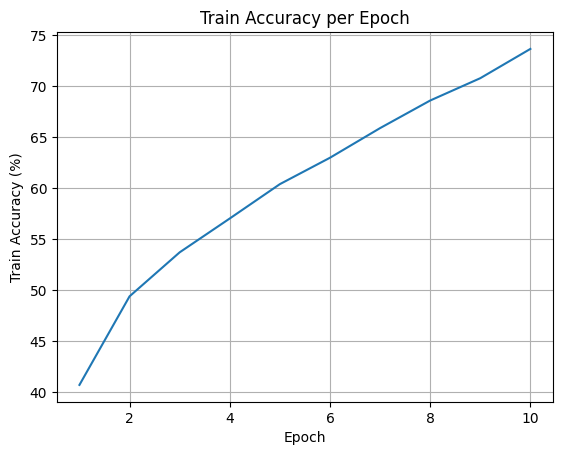

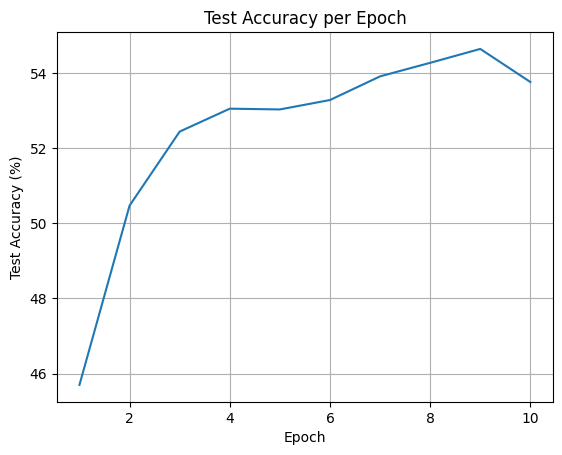

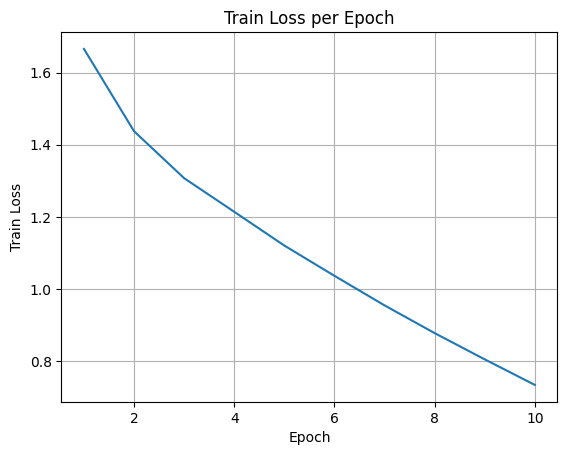

In [8]:
# 예시 실행
print("\n===== Training Deep (or Your) MLP =====")
model = MLP_NoSoftmax()  # 또는 MLP_WithSoftmax()
model, hist = train_model(model, trainloader, testloader, epochs=10, lr=1e-3)

# 1) Train Acc
plt.figure()
plt.plot(range(1, len(hist["train_acc"])+1), hist["train_acc"])
plt.xlabel("Epoch")
plt.ylabel("Train Accuracy (%)")
plt.title("Train Accuracy per Epoch")
plt.grid(True)
plt.show()

# 2) Test Acc (있을 때만)
if len(hist["test_acc"]) > 0:
    plt.figure()
    plt.plot(range(1, len(hist["test_acc"])+1), hist["test_acc"])
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy (%)")
    plt.title("Test Accuracy per Epoch")
    plt.grid(True)
    plt.show()

# 3) (옵션) Train Loss
plt.figure()
plt.plot(range(1, len(hist["train_loss"])+1), hist["train_loss"])
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Train Loss per Epoch")
plt.grid(True)
plt.show()
